# SQUID Tuning Minimal Conceptual Simulation

This demonstrates the essential actions to tune a SQUID.

It doesn't perform any of the error-checking that the real code does.

It also doesn't include any of the techniques used to deal with noisy data
or techniques used to minimize data collection
(such as interpolation between points for better resolution, or early exits from 
data collection when sufficient features have been found to allow tuning).

I've called out areas where we would require additional board communications 
in the code using `-->`

In [403]:
import numpy as np
from pylab import *
from scipy.interpolate import UnivariateSpline
import functools

rcParams.update({
        'font.size': 12,
        'mathtext.fontset': 'cm',
        'text.usetex': True,
        'legend.handlelength': 2,
         })
matplotlib.rc('font', **{'family':'sans-serif','sans-serif':['Computer Modern Roman']})
matplotlib.rc('font', **{'family':'serif','serif':['Computer Modern Roman']})
plt.rc('pgf', preamble=[r'\usepackage{siunitx}'])


In [404]:
### Dependencies for generating the current bias behavior
### Only needed for Joshua's initial generation of this code

# import pydfmux
# import pickle as pkl
# tdat = pkl.load(open('/home/joshua/winterlandlab/PhD_Figs/squid_tuning/dense_squid_tuning.pkl','r'))
# ex = tdat[tdat.keys()[75]] 
# cb = ex['cb_optimization']
# cb_dac_to_isquid = pydfmux.core.utils.transferfunctions.cb_dac_to_isquid
# voff = pydfmux.core.utils.transferfunctions.voffset_dac_to_vsquid
# ib = 1e6*(cb_dac_to_isquid(np.array(cb['v_p2p']['x']))-min(cb_dac_to_isquid(np.array(cb['v_p2p']['x']))))
# p2p = 1e3*(voff(np.array(cb['v_maxima']['y']))-voff(np.array(cb['v_minima']['y'])))

In [405]:
# Current biases in uA (from real data)
ib_data = [ 0.,2.0096463, 4.0192926, 6.02893891, 8.03858521, 10.04823151, 
      12.05787781, 14.06752412, 16.07717042, 18.08681672, 20.09646302, 22.10610932,
      24.11575563, 26.12540193, 28.13504823, 30.14469453, 32.15434084, 34.16398714,
      36.17363344, 38.18327974, 40.19292605, 42.20257235, 44.21221865, 46.22186495,
      48.23151125, 50.24115756, 52.25080386, 54.26045016, 56.27009646, 58.27974277,
      60.28938907, 62.29903537, 64.30868167, 66.31832797]


# Peak to Peak outputs in mV (from real data)
p2p_data = [0.00962432, 0.03919331, 0.1804734, 0.68373799, 1.31955485, 2.08891296,
       2.69010749, 3.35255558, 3.86755032, 4.36105768, 4.52966798, 4.06896779,
       3.40857466, 2.75051533, 2.32668268, 2.02728982, 1.79252, 1.60427754,
       1.46406358, 1.35701242, 1.27462602, 1.21426646, 1.14552372, 1.1114865,
       1.06394179, 1.0205743,  0.99776526, 0.96790862, 0.94341156, 0.93050587,
       0.91641045, 0.88600054, 0.88824673, 0.88817487]

# Model for how current bias modulates the peak-to-peak SQUID outputs
p2p_from_ib = UnivariateSpline(ib, p2p, s=.001)

<IPython.core.display.Javascript object>


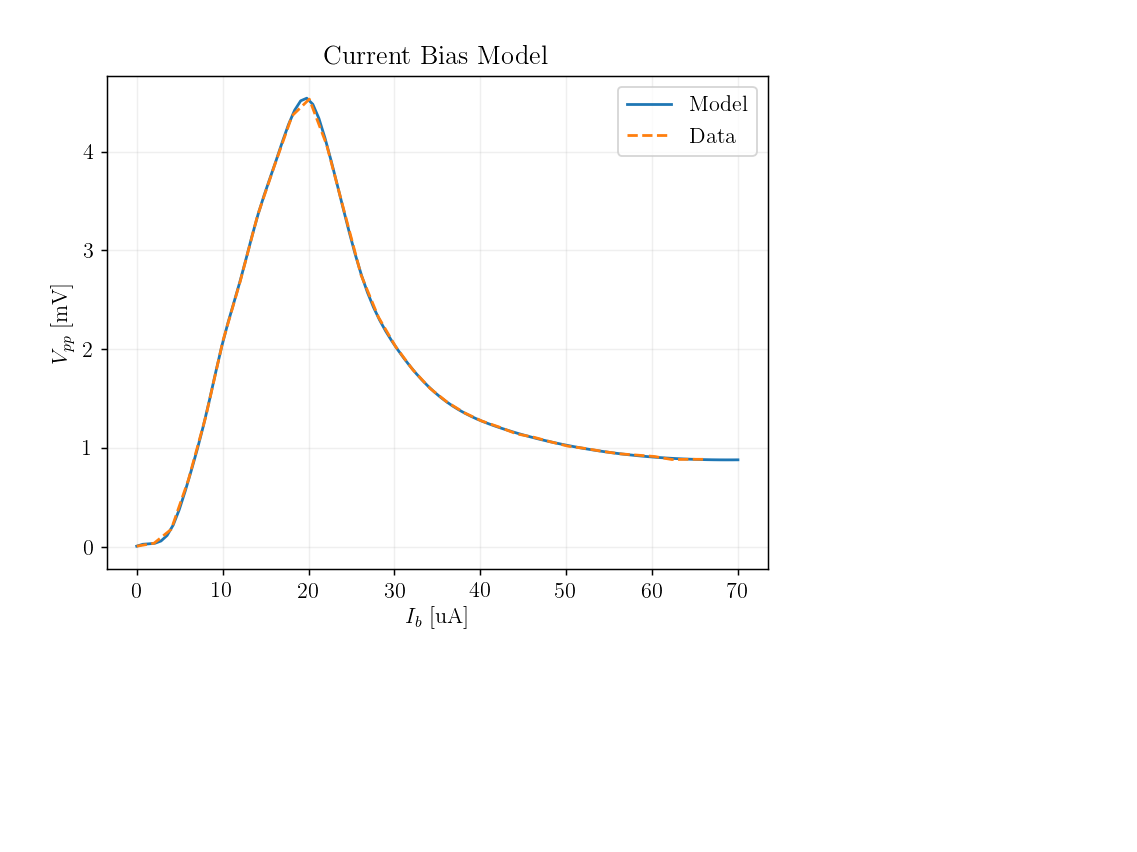

In [406]:
# Test our Current Bias model
%matplotlib notebook

ibs_test = np.linspace(0,70,100)
p2ps_test = p2p_from_ib(ibs_test)
plot(ibs_test, p2ps_test, label='Model')
plot(ib_data,p2p_data,'--',alpha=1, label='Data')
title("Current Bias Model")
ylabel('$V_{pp}$ [mV]')
xlabel('$I_b$ [uA]')
grid(alpha=0.2)
legend()

# Next we build our SQUID VPHI model

In [407]:
def vphi(ib, phi, rsh=1):
    """Possible Extensions: Adding noise (easy), glitches (easy), trapped flux (hard)"""
    # SA13 and StarCryo SQUIDs phase-shift ~linearly with current bias
    shifted_phi = phi-ib/15.
    
    # Partially analytic approximation of the SQUID VPHIs
    # Gets minima wrong (they are too pointy), 
    # but this is very hard to analytically express
    # For this simulator this is perfectly adequate, and gets all of the relevant
    # SQUID features.
    vout = ib/3. + (rsh * p2p_from_ib(ib) * np.sqrt(1-np.sin(shifted_phi)**2))

    return vout


# Test the SQUID VPHI model

<IPython.core.display.Javascript object>


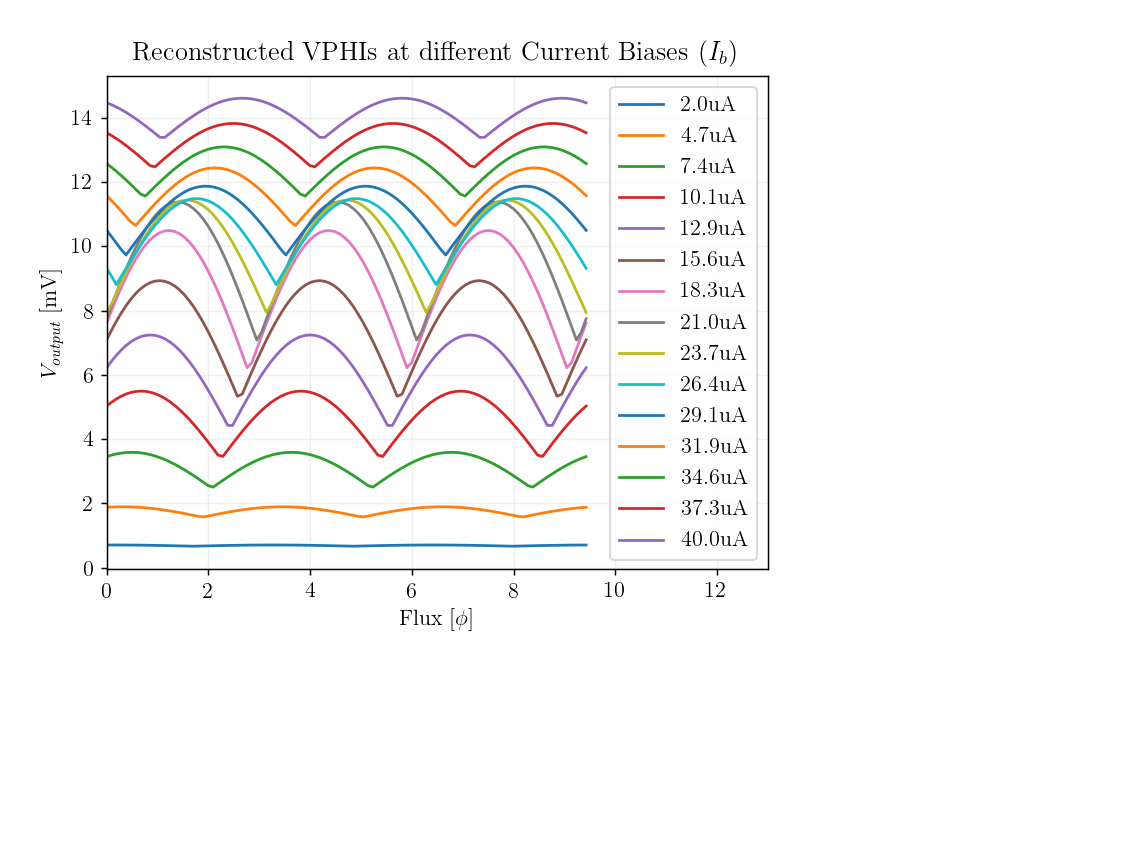

In [409]:
%matplotlib notebook
phis = np.linspace(0,3*np.pi,100)
ibs = np.linspace(2,40,15)

for i in ibs:
    plot(phis, vphi(i,phis,1), label='{0:.1f}uA'.format(i))
title('Reconstructed VPHIs at different Current Biases ($I_b$)')
xlim(0,13)
xlabel('Flux [$\phi$]')
ylabel('$V_{output}$ [mV]')
legend()
grid(alpha=0.2)

This looks pretty good! It gets the minima wrong (which flatten out in real SQUIDs), but that won't effect our demonstration simulation here.

# Recover the Current Bias model when extracted from full simulated SQUID VPHIs

<IPython.core.display.Javascript object>


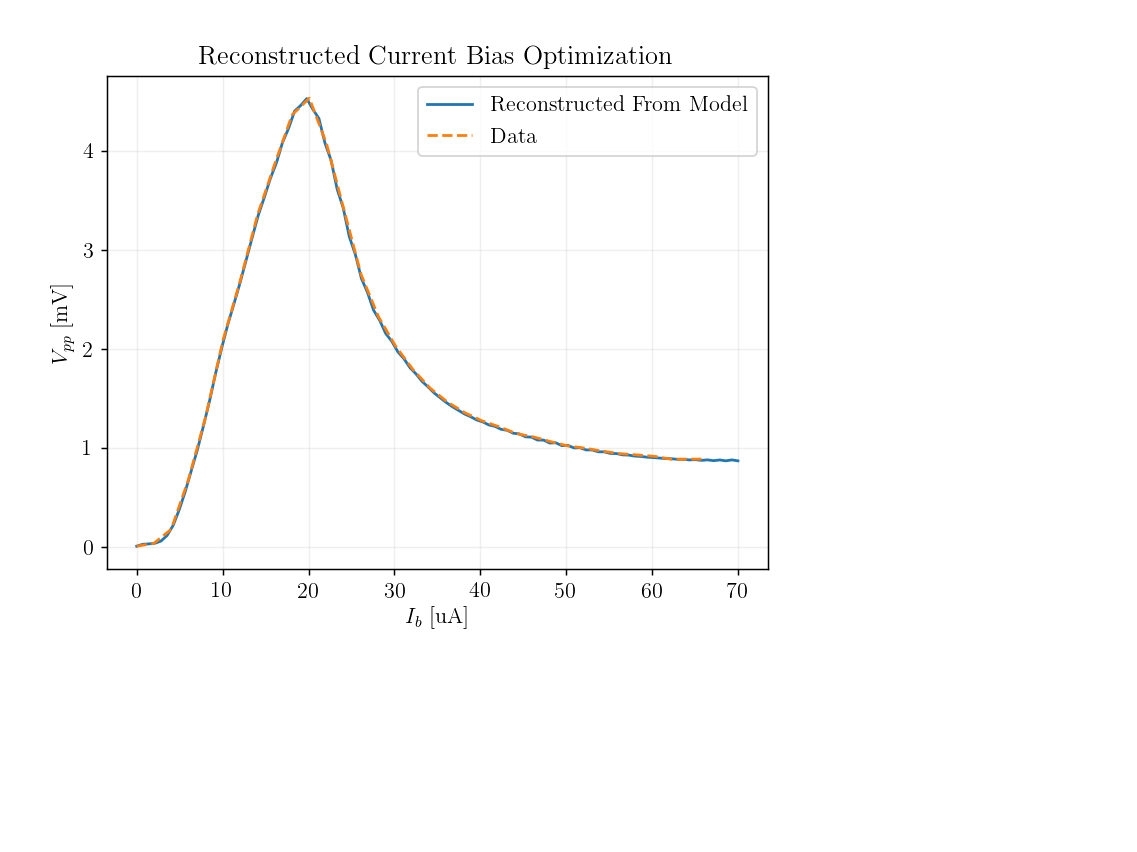

Text(0.5,1,'Reconstructed Current Bias Optimization')

In [410]:
%matplotlib notebook
figure()
phis = np.linspace(0,2*np.pi,100)
ibs = np.linspace(0,70,100)

vpp = []
for x,i in enumerate(ibs):
    vouts = vphi(i,phis,1)
    vpp.append(max(vouts)-min(vouts))
plot(ibs,vpp, label='Reconstructed From Model')
plot(ib_data, p2p_data, '--', alpha=1, label='Data')
legend()
grid(alpha=0.2)
ylabel('$V_{pp}$ [mV]')
xlabel('$I_b$ [uA]')
title('Reconstructed Current Bias Optimization')

# SQUID Tuning Simulation

In [411]:
# Dependency to find local extrema in an array
from scipy.signal import argrelextrema

In [412]:
def tune_squid(cb_min=0, 
               cb_max=70, 
               cb_npts=50, 
               phi_min=0, 
               phi_max=9, 
               phi_npts=50):
    
    ## Make the current and phi increment arrays
    cbs_arr = np.linspace(cb_min, cb_max, cb_npts)
    phis_arr = np.linspace(phi_min, phi_max, phi_npts)
    
    # First, find the optimum current bias
    v_p2ps = []
    for cb in cbs_arr:
        # Increment the current bias and begin mapping V-PHI curve
        # --> squid.set_current_bias(cb)
        intermediate_vphi = []
        for phi in phis_arr:
            # Increment flux bias and collect samples
            
            # --> squid.set_flux_bias(phi)
            # --> zero the offset DAC:
            # -->     adc.re_zero() (this is actually ~6 interactions with the board)
            # measure the resulting change in voltage at the ADC
            # --> vout = adc.get_offset()
            
            # Get the result from the model
            vout = vphi(cb, phi)
            
            # Store this in the intermediate vphi array
            intermediate_vphi.append(vout)

        # calculate dynamic range of this vphi
        p2p = max(intermediate_vphi)-min(intermediate_vphi) 
        v_p2ps.append(p2p)
    
    # The optimum current bias is the value that maximizes the
    # SQUID dynamic range
    cb_optimum = np.array(cbs_arr)[np.where(v_p2ps==max(v_p2ps))][0]
    
    # Find optimum flux bias
    final_vphi = []
    for phi in phis_arr:
        # Increment flux bias and collect samples

        # --> squid.set_flux_bias(phi)
        # --> zero the offset DAC:
        # -->     adc.re_zero() (this is actually ~6 interactions with the board)
        # measure the resulting change in voltage at the ADC
        # --> vout = adc.get_offset()

        vout = vphi(cb_optimum, phi)
            
        # Store this in the intermediate vphi array
        final_vphi.append(vout)
    
    final_vphi = np.array(final_vphi) # easier to manipulate as an array
    
    # Find index of first of two maxima of this vphi
    nmaxes = argrelextrema(np.array(final_vphi), np.greater, order=2)[0]
    # --> Complain if there are not two maxima (flux bias range too low, or issue with SQUID)
    # --> Do some cleaning to remove false peaks
    
    # first maximum:
    nmax = nmaxes[0]
    
    # Find index of first minimum following the first maximum
    nmins = argrelextrema(np.array(final_vphi), np.less, order=2)[0]
    # --> Complain if no local minimum between the two maxes
    
    # Find first minimum after the maximum (so we are on negative slope)
    nmin = np.min(nmins[nmins > nmax])

    # There are two ways to easily find the point where the slope is max
    # 1) find the flux bias where flux_bias=(vout_max+vout_min)/2
    # 2) find the mean flux bias between max and min
    # Empirically the best point is the mean of these two
    
    # Find closest point to the midpoint
    vout_mid = (final_vphi[nmax]+final_vphi[nmin])/2.
    phi_vout_mid = phis_arr[nmax+np.argmin(abs(final_vphi[nmax:nmin]-vout_mid))]
    
    # --> use a linear interpolation to overcome granularity of vphi measurements
    
    # Midpoint in phi between max and min of vphi is easier:
    phi_phi_mid = (phis_arr[nmax] + phis_arr[nmin])/2.
        
    # Optimum choice is the midpoint of these
    phi_optimum = (phi_vout_mid + phi_phi_mid)/2.
    
    # Program these optimum points
    # --> squid.set_current_bias(cb_optimum)
    # --> squid.set_flux_bias(phi_optimum)
    
    # --> Measure the transimpedance at this point
    # --> ~5 interactions with the board to measure Z
    
    return cb_optimum, phi_optimum

# Validate these bias points

In [413]:
cb_optimum, phi_optimum = tune_squid()

<IPython.core.display.Javascript object>


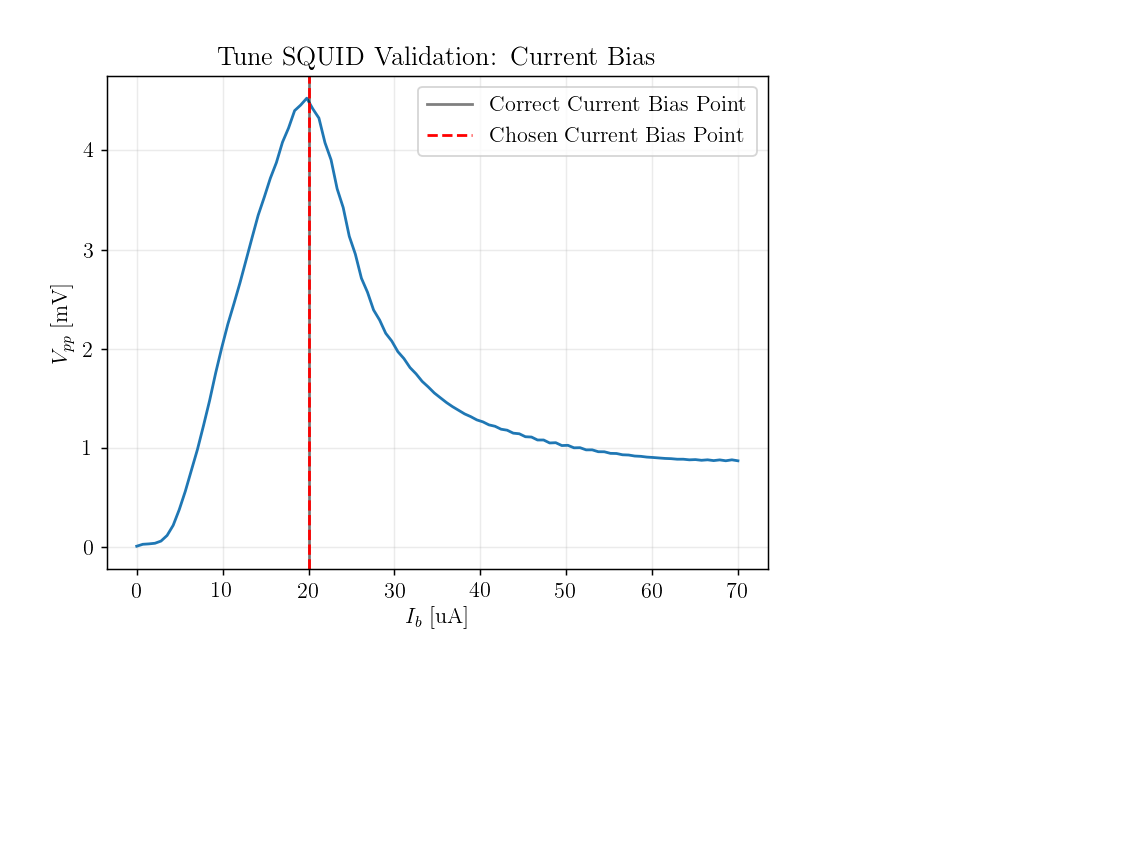

<IPython.core.display.Javascript object>


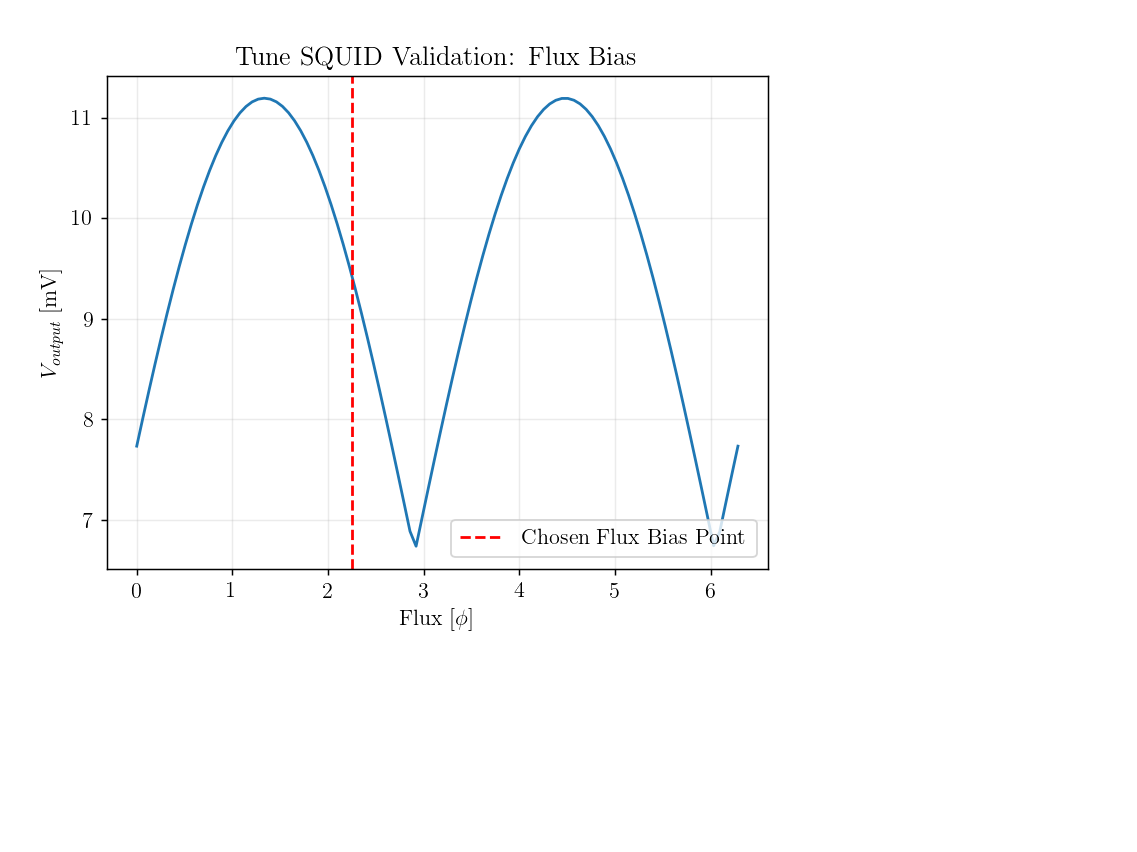

In [414]:
%matplotlib  notebook
figure()
cbs = np.linspace(0,70,100)
phis = np.linspace(0,np.pi*2,100)

vpp = []
for x,i in enumerate(ibs):
    vouts = vphi(i,phis,1)
    vpp.append(max(vouts)-min(vouts))
plot(ibs,vpp)
title('Tune SQUID Validation: Current Bias')
axvline(np.array(ib_data)[np.where(np.array(p2p_data)==max(p2p_data))], 
        color='k', 
        linestyle='-', 
        label='Correct Current Bias Point',
        alpha=0.5)
axvline(cb_optimum, color='red', linestyle='dashed', label='Chosen Current Bias Point')
grid(alpha=0.25)
ylabel('$V_{pp}$ [mV]')
xlabel('$I_b$ [uA]')
legend()

figure()
plot(phis, vphi(cb_optimum,phis,1))
axvline(phi_optimum, color='red', linestyle='dashed', label='Chosen Flux Bias Point')
title('Tune SQUID Validation: Flux Bias')
legend()
xlabel('Flux [$\phi$]')
ylabel('$V_{output}$ [mV]')
grid(alpha=0.25)

## Compare to real data outputs and chosen flux bias (of the same SQUID):
Note -- X-axis is not in the same units because the semi-analytic model doesn't
include the electronic DAC that produces Flux using a current bias.

![title](fb_optimization.png)